In [244]:
%matplotlib inline

In [198]:
import scipy.io as sio
import networkx as nx
from helpers import signed_laplacian
from core import query_graph_using_sparse_linear_solver

In [199]:
mat_contents = sio.loadmat('data/word_sim_weighted.mat')

In [200]:
A = mat_contents['Wemb']
names = mat_contents['names']
i2w = {i: names[i][0][0] for i in range(A.shape[0])}
w2i = {w: i for i, w in i2w.items()}

In [201]:
g = nx.from_scipy_sparse_matrix(A, edge_attribute='sign')

In [202]:
gc = max(nx.connected_component_subgraphs(g), key=len)
mapping = {n: i for i, n in enumerate(gc.nodes())}
w2i_new = {i2w[old]: new for old, new in mapping.items()}
i2w_new = {new: i2w[old] for old, new in mapping.items()}

gc = nx.relabel_nodes(gc, mapping=mapping)
w2i = w2i_new
i2w = i2w_new
del g

In [203]:
def pos_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] > 0]

def neg_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] < 0]

print(' '.join(pos_nbrs(gc, 'happy')))
print(' '.join(neg_nbrs(gc, 'happy')))

light content fit fitting cheerful successful jolly good nice sparkling accidental proper right promising upbeat ready incidental well smiling willing meet glad
poor melancholic ashamed unhappy blue serious unfortunate boiling down downcast disagreeable upset heavy sad dark


In [263]:
from core import query_graph_using_sparse_linear_solver

words1, words2 = ['happy'], ['unhappy']
seeds = [[w2i[w] for w in words1], [w2i[w] for w in words2]]
x_opt, opt_val = query_graph_using_sparse_linear_solver(gc, seeds, kappa=0.8, verbose=1)

matrices loading done
found lambda_1= (0.02954934141842109+0j)
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.10534945950146324
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.10529420429600755
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.06817775652856628
at iteration 20 (alpha=-1.49728)
residual: sqrt(kappa) - y' D s=-0.007096183642422593
terminates after 22 iterations:
  - alpha=-1.42992
  - residual=-0.00051


In [264]:
from core import sweep_on_x
c1, c2, C, best_sbr, ts, sbr_list = sweep_on_x(gc, x_opt, top_k=200, verbose=1)

  0%|          | 1/200 [00:00<00:23,  8.30it/s]

sweep on top 200


100%|██████████| 200/200 [00:43<00:00,  5.12it/s]

best_t: 0.0036890274827451122
comm1: [ 351  360  423  424  881 1132 1133 1794 1864 2007 2314 2670 3007 3773
 4001 4072 4282 4501 4605 4702 4797]
comm2: [  18   30  166  346  705 1517 1597 1774 2067 3326 3385 3818 3823 3954
 3974 4100 4183 4368 4569 4828 4902 4932 4942]


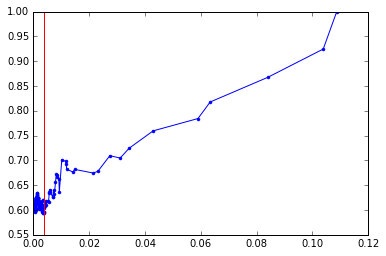

In [266]:
from matplotlib import pyplot as plt
plt.plot(ts, sbr_list, '.-')
plt.axvline(0.0036890274827451122, color='red')

In [268]:
print(' '.join([i2w[n] for n in c1]))
print(' '.join([i2w[n] for n in c2]))
len(c1), len(c2)

blue boiling broiling brunette defeatist downbeat downcast hurting impromptu insurgent melancholic penitent repellent unfortunate worrying ashamed dreary navy sad unhappy disagreeable
absorbent accidental antiseptic blonde content freezing glad hopeful jolly smiling sparkling upbeat uplifting well willing beautiful cheerful happy proud freely promising skillfully sweetened


(21, 23)

/home/cloud-user/code/signed/helpers.py:355: RuntimeWarning: divide by zero encountered in true_divide
  


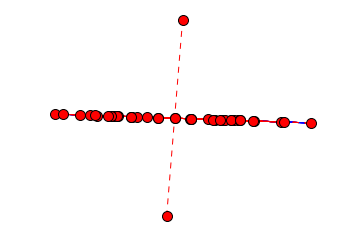

In [269]:
from helpers import signed_layout, draw_nodes, draw_edges, get_borderless_fig
subg = gc.subgraph(C)

subg = nx.convert_node_labels_to_integers(subg)
pos = signed_layout(subg, normalize=True)

fig, ax = get_borderless_fig()
# draw_nodes(subg, pos, ax=ax)
nx.draw_networkx_nodes(subg, pos, node_size=100)
draw_edges(subg, pos, ax=ax)

# observation


- single query node: may return multiple opposing communities
- if kappa not set properly (e.g, 0.5), will return weird result (even not including the seed nodes), not sure why
- however, if set high enough (0.8 for example), meaningful result is returned
